In [1]:
# Imports
import sys

from tqdm import tqdm

import torch
import numpy as np
import matplotlib.pyplot as plt

cuda = torch.cuda.is_available()
%matplotlib inline

# Ladder Variational Autoencoder

The ladder variational autoencoder (LVAE) [[Sønderby 2016a]](https://arxiv.org/abs/1602.02282) adds several stochastic layers to the VAE and performs both bottom-up and top-down merging of information to provide a better estimate of the log likelihood of data. The model is non-trivial, as evidenced by the diagram below.

<img src="../images/ladder.png" width="300px"/>

Where left is the inference model and right is the generative model. The number of stochastic layers is not predetermined and can be chosen to be any number as long as the two parts agree.

In [2]:
from semi.models import LadderVariationalAutoencoder

# Bottom to top
z_dim = [32, 16, 8]
h_dim = [256, 128, 64]

model = LadderVariationalAutoencoder([784, z_dim, h_dim])
model

LadderVariationalAutoencoder(
  (encoder): ModuleList(
    (0): LadderEncoder(
      (linear): Linear(in_features=784, out_features=256, bias=True)
      (batchnorm): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (sample): GaussianSample(
        (mu): Linear(in_features=256, out_features=32, bias=True)
        (log_var): Linear(in_features=256, out_features=32, bias=True)
      )
    )
    (1): LadderEncoder(
      (linear): Linear(in_features=256, out_features=128, bias=True)
      (batchnorm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (sample): GaussianSample(
        (mu): Linear(in_features=128, out_features=16, bias=True)
        (log_var): Linear(in_features=128, out_features=16, bias=True)
      )
    )
    (2): LadderEncoder(
      (linear): Linear(in_features=128, out_features=64, bias=True)
      (batchnorm): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

## Training

We still want to maximise the same lower bound as described in the VAE notebook, the difference here is that both the generative model and the inference model are now hierarchical.

$$p_{\theta}(z) = p_{\theta}(z_L) \prod_{i=1}^{L-1} p_{\theta}(z_i|z_{i+1})$$
$$q_{\phi}(z|x) = q_{\phi}(z_1|x) \prod_{i=2}^{L} q_{\phi}(z_i|z_{i+1})$$

Which results in a KL-divergence between the latent distributions of their respective p and q layers. All of this is handled directly within the model.

Additionally, training hierarchical deep generative models is prone to collapsing fo the stochastic units - meaning that these become inactive during training. This problem can be avoided by gradually turning on the KL-term during turning [[Sønderby 2016b]](http://orbit.dtu.dk/files/121765928/1602.02282.pdf). Typically one starts out training the model with no, or little influence of the KL-term ($\beta \approxeq 0$). Then after each epoch, the temperature is raised to $\beta = 1$.

This warm-up scheme has been implemented as an iterator as `DeterministicWarmup`.

In [6]:
from semi.data import get_mnist
from semi.inference import DeterministicWarmup

_, loader_train, loader_validation = get_mnist(location="./", batch_size=64, num_workers=0)

def binary_cross_entropy(r, x):
    return -torch.sum(x * torch.log(r + 1e-8) + (1 - x) * torch.log(1 - r + 1e-8), dim=-1)

optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, betas=(0.9, 0.999))
beta = DeterministicWarmup(n=50, t_max=1) # Linear warm-up from 0 to 1 over 50 epochs

In [7]:
from torch.autograd import Variable

for epoch in range(50):
    model.train()
    total_loss = 0
    for (u, _) in tqdm(loader_train):
        u = Variable(u)

        if cuda: u = u.cuda(device=0)

        reconstruction = model(u)
        
        likelihood = -binary_cross_entropy(reconstruction, u)
        elbo = likelihood - next(beta) * model.kl_divergence
        
        loss = -torch.mean(elbo)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.item()

    m = len(train)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch+1}\tL: {total_loss / m:.2f}")

 21%|██▏       | 200/938 [00:31<02:16,  5.43it/s]

KeyboardInterrupt: 

## Sampling from the generative model

To sample from the network we pass some normal distributed noise $z \sim N(0, I)$ to the top most layer of the decoder and pass the representation through the layers to arrive at our final generated data.

In [8]:
model.eval()
x_mu = model.sample(Variable(torch.randn(16, 8)))

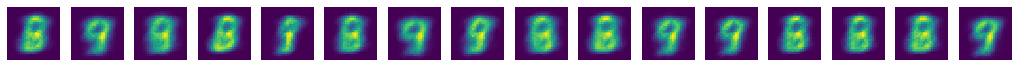

In [9]:
f, axarr = plt.subplots(1, 16, figsize=(18, 12))

samples = x_mu.data.view(-1, 28, 28).numpy()

for i, ax in enumerate(axarr.flat):
    ax.imshow(samples[i])
    ax.axis("off")